<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:

# Mount Google Drive
#drive.mount('/content/drive')

# Navigate to your folder
#folder_path = '/content/drive/MyDrive/PlantVillage'




In [4]:

# Set the path to the dataset directory
dataset_dir = r'C:\Users\Lisa\Desktop\PlantDisease\Tomato'  

## 2. Loading our dataset.

In [5]:
data= tf.keras.utils.image_dataset_from_directory(dataset_dir, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16011 files belonging to 10 classes.


In [6]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

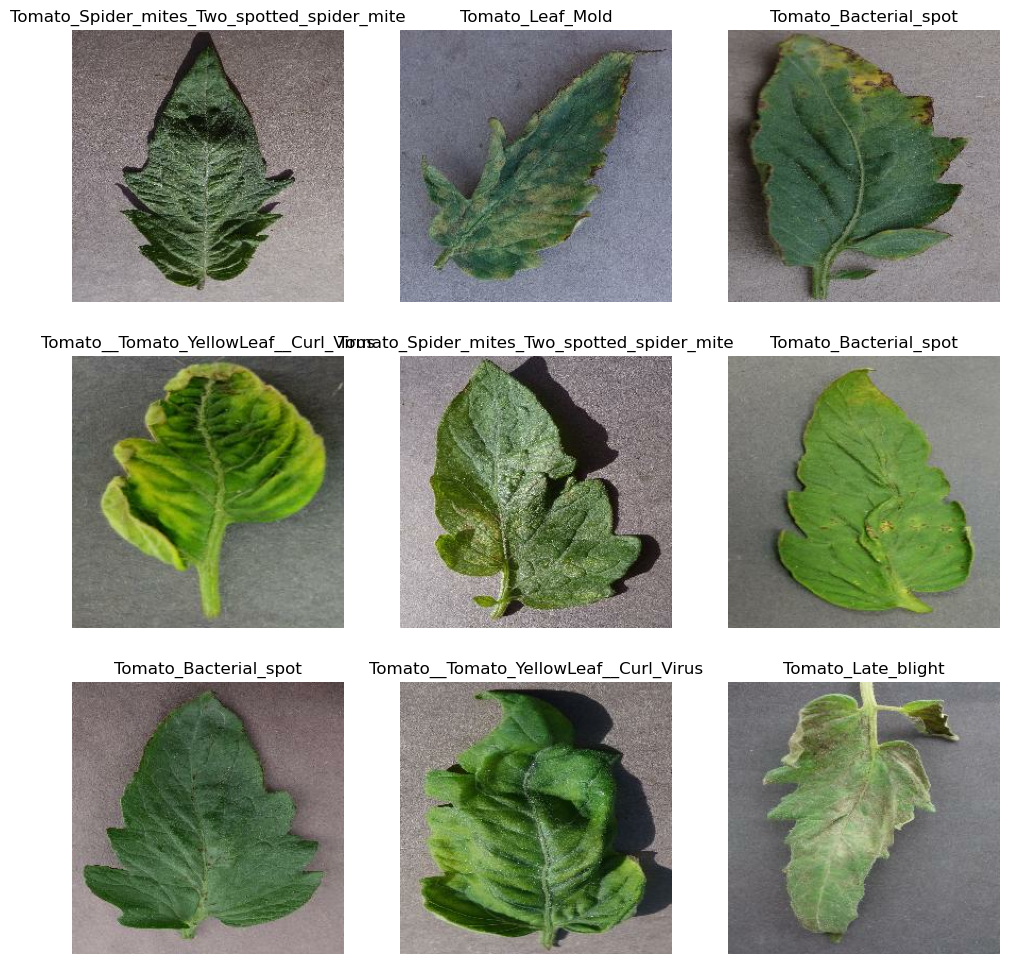

In [7]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [8]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

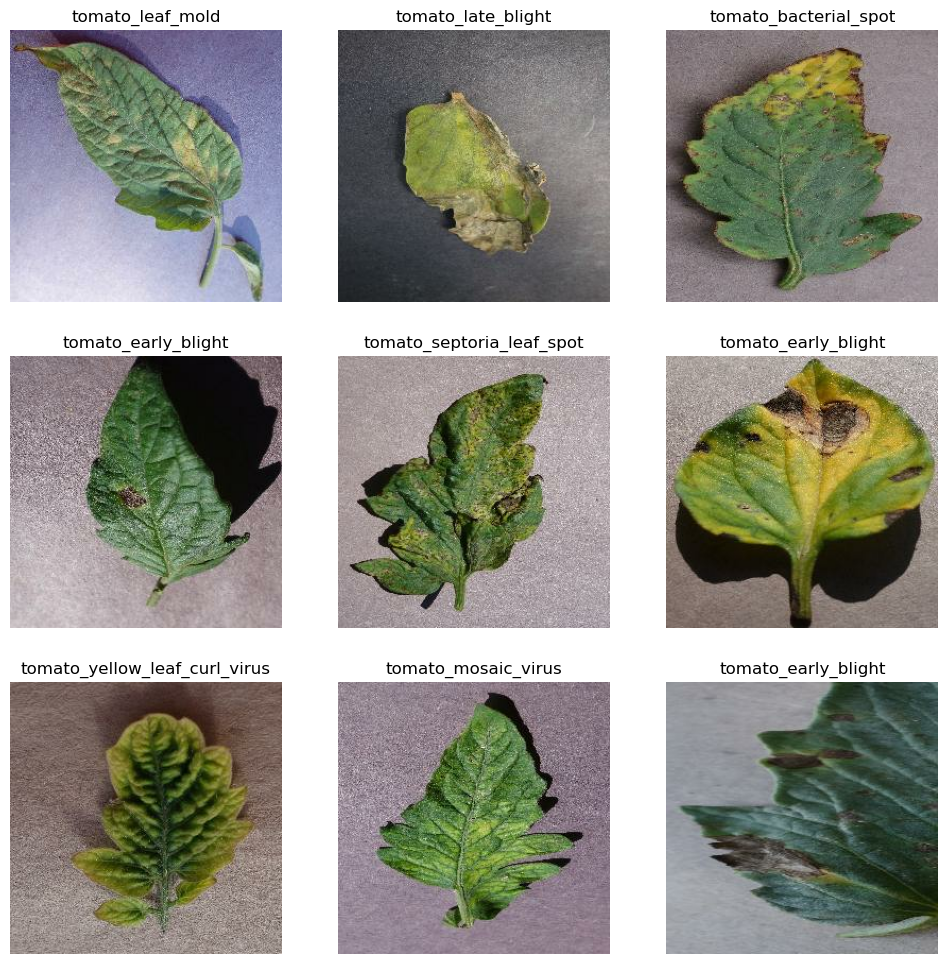

In [10]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [11]:
def check_corrupt_images(dataset_dir):
    corrupt_images = []
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(dataset_dir)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [12]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

**Class Distribution**

In [13]:
# A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1591, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1909, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


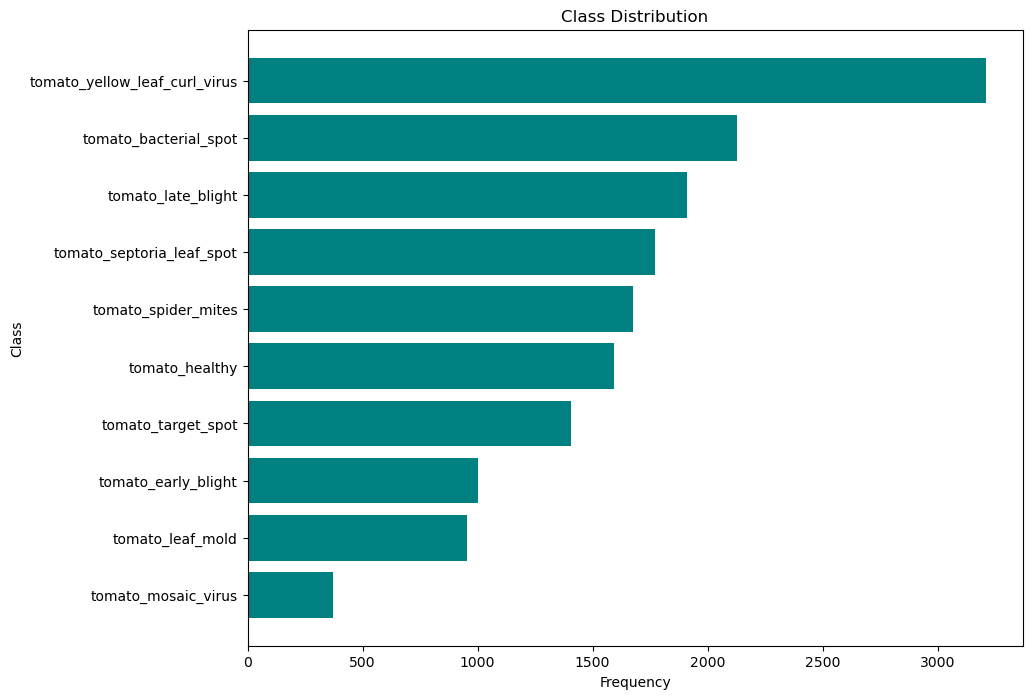

In [14]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

# Data Modeling

**RESNET 50 MODEL**

In [15]:
# Set image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
#CHUNK_SIZE = 1024

batch_size = BATCH_SIZE
image_size = IMG_SIZE
#chunk_size = CHUNK_SIZE

In [16]:
# Preprocessing function
def preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label


In [17]:
# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])


In [18]:

# Function to create the model
def create_model():
    base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_SIZE + (3,)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Adjust output layer size
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

# Split the dataset into train, validation, and test sets
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size - test_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Apply data augmentation only to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 16011 files belonging to 10 classes.


In [20]:
train_dataset = train_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
# Create and train the model
model = create_model()

C:\Users\Lisa\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)




Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1490s 4s/step - accuracy: 0.6800 - loss: 0.9886 - val_accuracy: 0.9013 - val_loss: 0.2865
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1671s 4s/step - accuracy: 0.8769 - loss: 0.3667 - val_accuracy: 0.9137 - val_loss: 0.2496
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1777s 4s/step - accuracy: 0.9020 - loss: 0.2868 - val_accuracy: 0.9200 - val_loss: 0.2368
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1742s 4s/step - accuracy: 0.9128 - loss: 0.2444 - val_accuracy: 0.9456 - val_loss: 0.1516
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1744s 4s/step - accuracy: 0.9306 - loss: 0.2064 - val_accuracy: 0.9431 - val_loss: 0.1780
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1809s 4s/step - accuracy: 0.9306 - loss: 0.2046 - val_accuracy: 0.9494 - val_loss: 0.1520
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1777s 4s/step - accuracy: 0.9277 - loss: 0.2000 - val_accuracy: 0.9500 - val_loss: 0.1577


In [25]:
# Get the optimum number of epochs
optimum_epochs = len(history.history['val_accuracy']) - early_stopping.patience

# Print the optimum number of epochs
print("Optimum number of epochs:",optimum_epochs)

Optimum number of epochs: 4


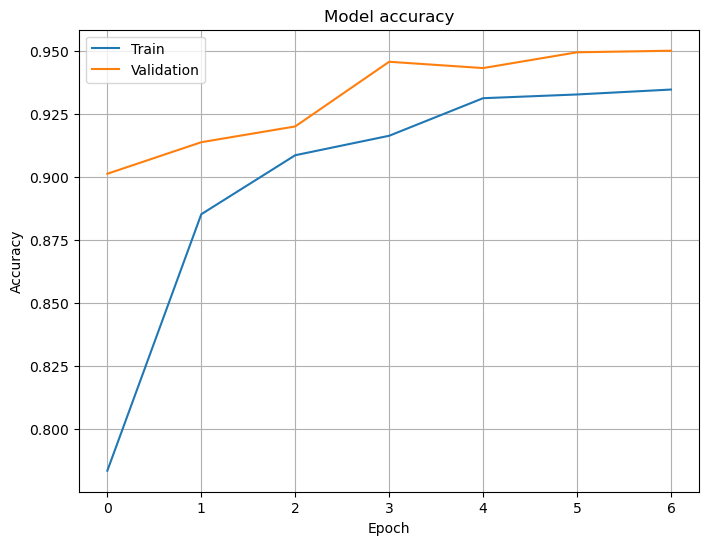

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [27]:
# Evaluate the model
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Validation accuracy: {test_acc}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9432 - loss: 0.1392
Validation accuracy: 0.9443749785423279


In [29]:
model.save('trained_model.keras')

In [30]:
history.history

{'accuracy': [0.7835879325866699,
  0.8852088451385498,
  0.9085879325866699,
  0.9163029789924622,
  0.931187629699707,
  0.9326683282852173,
  0.9346165657043457],
 'loss': [0.6471458673477173,
  0.33750036358833313,
  0.27145689725875854,
  0.23886823654174805,
  0.20315730571746826,
  0.19831566512584686,
  0.1886429637670517],
 'val_accuracy': [0.9012500047683716,
  0.9137499928474426,
  0.9200000166893005,
  0.9456250071525574,
  0.9431250095367432,
  0.9493749737739563,
  0.949999988079071],
 'val_loss': [0.28645357489585876,
  0.249630406498909,
  0.23678535223007202,
  0.15160579979419708,
  0.1780250370502472,
  0.1519707590341568,
  0.1576591432094574]}

In [31]:
import json
with open('history.json','w') as f:
    json.dump(history.history,f)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('trained_model.keras')
